# Pip Installs

In [83]:
%%capture

!pip install librosa
!pip install tensorflow
!pip install numpy==1.23.5
!pip install pysoundfile
!pip install alive-progress
!pip install --upgrade pytube

Tensor flow does not work with Numpy 2.0 onward so make sure that 

# Imports

Below are the necessary imports 

In [84]:
#Imports
from pydub import AudioSegment as audio
import os
import numpy as np
import librosa
#Tensor Flow needs numpy at 1.23.5
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import re 
import soundfile as sf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from alive_progress import alive_bar
import yt_dlp

# File Creation

### Creating File Paths

In [ ]:
unprocessed_data_dir = os.path.abspath('') + "/Unprocessed_Training_Wav_Files"
procesed_data_dir = os.path.abspath('') + "/Processed_Training_Wav_Files"

# YouTube Audio Download

In [ ]:
def download_audio(url, starttime, endtime, output):
    # Convert start and end times to seconds
    hours, minutes, seconds = map(int, starttime.split(':'))
    start_time = hours * 3600 + minutes * 60 + seconds
    hours, minutes, seconds = map(int, endtime.split(':'))
    end_time = hours * 3600 + minutes * 60 + seconds
    
    """ 
    ydl_opts = {
        'format': 'bestaudio/best',  # Download the best audio format
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',  # Extract audio after download
            'preferredcodec': 'wav',  # Convert to wav format
        }],
        'noplaylist': True,  # Avoid downloading playlists, download a single video
        'quiet': False,  # Show output in the terminal
        'outtmpl': 'temp_audio.%(ext)s',  # Temporary output for the full audio
    }

    #Use yt-dlp to download the audio
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    """
    #Load the downloaded audio using pydub (assume the file was saved as temp_audio.wav)
    audio_file = audio.from_wav('temp_audio.wav')

    #Extract the desired clip (convert time to milliseconds)
    start_time_ms = start_time * 1000  # Convert start time from seconds to milliseconds
    end_time_ms = end_time * 1000      # Convert end time from seconds to milliseconds
    clip = audio_file[start_time_ms:end_time_ms]

    #Export the extracted clip as a new WAV file
    clip.export(output, format="wav")
    print(f"Audio clip saved to {output}")

    #Clean up the temporary file
    #os.remove('temp_audio.wav')

starttime = '2:49:59' 
endtime = '2:53:16'
name = 'dinaTitus40533Clip1'
download_audio(url='https://www.youtube.com/watch?v=EELSevWNbIk',
               starttime=starttime,
               endtime=endtime,
               output=f'{unprocessed_data_dir}/{name}.wav')

[youtube] Extracting URL: https://www.youtube.com/watch?v=EELSevWNbIk
[youtube] EELSevWNbIk: Downloading webpage
[youtube] EELSevWNbIk: Downloading ios player API JSON
[youtube] EELSevWNbIk: Downloading mweb player API JSON
[youtube] EELSevWNbIk: Downloading player 5b77d519


         player = https://www.youtube.com/s/player/5b77d519/player_ias.vflset/en_US/base.js
         n = 9H9KK8HJuZ1wt6srg ; player = https://www.youtube.com/s/player/5b77d519/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/5b77d519/player_ias.vflset/en_US/base.js
         n = 8mh8ShJmjXdOxpNEP ; player = https://www.youtube.com/s/player/5b77d519/player_ias.vflset/en_US/base.js


[youtube] EELSevWNbIk: Downloading m3u8 information
[info] EELSevWNbIk: Downloading 1 format(s): 251
[download] Destination: temp_audio.webm
[download] 100% of  255.41MiB in 00:00:11 at 22.43MiB/s    
[ExtractAudio] Destination: temp_audio.wav
Deleting original file temp_audio.webm (pass -k to keep)
Audio clip saved to /Users/ryanbirmingham/Downloads/Sunwater Projects/congressional_voice_classification/Unprocessed_Training_Wav_Files/dinaTitus40533Clip1.wav


Steps
- go through all files in the unprocessed wav files
- break up all files so they are split by 1 second
- use regex to get the file name minus the .wav at the end to make new 1 second wav files
- save each of the files into the processed wav folder

Resample the unproccessed audio files for speaker recognition. This is needed for tensorflow and keras

In [ ]:
#This was a test for the fixing the audio with a single thing

"""
f_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
new_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)
sf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)
"""


'\nf_path = os.path.join(unproccessed_data_dir, "addisonWilson40173Clip1.wav")\narr, hz = librosa.load(f_path, sr = None)\nnew_f = librosa.resample(arr, orig_sr= hz, target_sr= 16000)\nsf.write(os.path.join(unproccessed_data_dir,"new.wav"),new_f, 16000)\n'

### Changes the Unporcessed_Wav_Files into 16000 hz

This is necessary for speaker recognition model training and feature extractions

In [86]:
for file in os.listdir(unprocessed_data_dir):
    if file != ".DS_Store":
        f_path = os.path.join(unprocessed_data_dir, file)
        arr, hz = librosa.load(f_path,sr = None)
        if hz != 16000:
            new_f = librosa.resample(arr, orig_sr = hz, target_sr = 16000)
            sf.write(f_path, new_f, 16000)

This is a test

In [6]:
f_path = os.path.join(unprocessed_data_dir, "addisonWilson40173Clip1.wav")
arr, hz = librosa.load(f_path, sr = None)
print(hz)

16000


## Remove the .DS_Store 
### This is a hiddent directory automatically created by Mac OS and causes errors

In [ ]:
for folder in procesed_data_dir:
    path = os.path.join(folder, ".DS_Store")
    if folder == ".DS_Store":
        os.remove('.DS_Store')
    elif os.path.exists(path):
        os.remove(path)     

### Separates the files into 1 second intervals

In [ ]:
for filename in os.listdir(unprocessed_data_dir):
    if filename.endswith(".wav"):
        hearing = audio.from_wav(os.path.join(unprocessed_data_dir,filename))
        speaker = filename.removesuffix(".wav")
        #name of congress person for processed_wav_files folder
        congress_name = speaker[:re.search(r"\d+",speaker).start()] 
        #start duration in milliseconds for audio recording start
        t1 = 0
        #end duration in milliseconds for audio recording start
        t2 = 1000
        #second of the clip
        second = 1
        total_time = hearing.duration_seconds*1000
        # Goes through all of the large audio files, splits them into 1 second audio files
        # and saves to the speaker name folder
        while t2 <= total_time:
            new_audio = hearing[t1:t2]
            #arr, hz = librosa.load(new_audio, sr = None)
            try:
                os.makedirs(f"{procesed_data_dir}/{congress_name}")
                new_audio.export(f"{procesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
            except:
                #new_audio.export(f"{proccesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav", parameters=["-ar", "16000"]);
                new_audio.export(f"{procesed_data_dir}/{congress_name}/{speaker}_{second}.wav", format = "wav");
            t1 += 1000
            t2 += 1000
            second += 1

Check the Hz of a split file

In [95]:
a,b = librosa.load(os.path.abspath('')  + "/Processed_Training_Wav_Files/stephenCohen/stephenCohen40173Clip1_57.wav", sr = None)
print(b)

16000


## Feature Extraction

    The code below captures the spectral characteristics of the congress person speaking
    during the audio clip. This process mimics how people perceive and identify voices.
    The feature extraction below uses features which are derived from the Mel Scale and 
    cepstrum. These features are then used to train the model to identify patterns in 
    speaker voices. 

In [ ]:
num_data = 0

for foldr in os.listdir(procesed_data_dir):
    if foldr != ".DS_Store":
        num_data += len(os.listdir(f"{procesed_data_dir}/{foldr}"))

In [ ]:
def feature_extract (data_dir):
    features = []
    labels = []
    with alive_bar(num_data,force_tty=True, title='Collecting Features', bar = 'scuba') as bar: 
        for foldr in os.listdir(data_dir):
            if foldr != ".DS_Store":
                for file in os.listdir(f"{data_dir}/{foldr}"):
                    arr, hz = librosa.load(os.path.join(data_dir,foldr,file), sr = None, duration =  1)
                    mfccs = librosa.feature.mfcc(y = arr, sr = hz, n_mfcc = 13)
                    mfccs = StandardScaler().fit_transform(mfccs)
                    features.append(mfccs.T)
                    labels.append(foldr)
                    bar()
                 
                
    return np.array(features), np.array(labels)           
features, labels = feature_extract(procesed_data_dir)

on 0: mikeThompson40610Clip1_109.wav                                            
on 1: mikeThompson40610Clip1_121.wav                                            
on 2: mikeThompson40610Clip1_135.wav                                            
on 3: mikeThompson40610Clip1_10.wav                                             
on 4: mikeThompson40610Clip1_38.wav                                             
on 5: mikeThompson40610Clip1_39.wav                                             
on 6: mikeThompson40610Clip1_11.wav                                             
on 7: mikeThompson40610Clip1_134.wav                                            
on 8: mikeThompson40610Clip1_120.wav                                            
on 9: mikeThompson40610Clip1_108.wav                                            
on 10: mikeThompson40610Clip1_136.wav                                           
on 11: mikeThompson40610Clip1_122.wav                                           
on 12: mikeThompson40610Clip

AttributeError: module 'soundfile' has no attribute 'SoundFileRuntimeError'

### Feature Visualization

In [ ]:
for feature_set, label in zip(features, labels[74:150]):
    print(f"Label: {label}, Features Shape: {feature_set.shape}")
    print(feature_set[0])  # Optionally print the actual features
    print("-" * 40)  # Separator for readability

Label: garretGraves, Features Shape: (32, 13)
[-3.15203571e+00  1.56118345e+00  6.61773503e-01  1.50649548e-01
 -1.68926036e-03  7.85192996e-02  2.02353269e-01  2.83961803e-01
  1.09830983e-01  1.03079937e-01 -1.01538815e-01  6.91628531e-02
  3.47488634e-02]
----------------------------------------
Label: garretGraves, Features Shape: (32, 13)
[-3.43573     0.4812946   0.0735459   0.39213693  0.52064437  0.1833697
  0.26637504  0.32702762  0.21333092  0.38059518  0.10706963  0.23304899
  0.25729108]
----------------------------------------
Label: garretGraves, Features Shape: (32, 13)
[-3.3647404   0.89822334  0.6880349   0.21407369  0.33554468  0.16783503
  0.04589068  0.10271491  0.09085961  0.33379367  0.15804197  0.17088644
  0.15884127]
----------------------------------------
Label: garretGraves, Features Shape: (32, 13)
[-2.8598819   1.9494504   0.25191608  0.4032747   0.59752816 -0.16175383
 -0.13915981 -0.22937572 -0.11941845  0.20550291 -0.24632241 -0.11017006
  0.45840994]
-

### Training and splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= .2, random_state= 42)

In [ ]:
label_encoder = LabelEncoder()
label_enc = label_encoder.fit_transform(labels)

In [ ]:
#Original shape shows n_samples, n_features, and n_channels
print(X_train.shape)
print(y_train.shape)

(8262, 32, 13)
(8262,)


### Reshape for SVM since it takes 2D arrays

In [ ]:
X_train_SVM = X_train.reshape(X_train.shape[0], -1)
X_test_SVM = X_test.reshape(X_test.shape[0], -1)

In [ ]:
print(X_train_SVM.shape)
print(y_train.shape)
#print(X_train_SVM)
print(y_train)

(8262, 416)
(8262,)
['stephenCohen' 'jerroldNadler' 'maryPeltola' ... 'troyCarter'
 'eleanorNorton' 'addisonWilson']


### Trying the SVM approach

In [ ]:
clm = SVC(kernel="linear", probability=True)

clm.fit(X_train_SVM,y_train)

y_predict = clm.predict(X_test_SVM)
incorrect = y_predict != y_test
print((len(y_test) - sum(incorrect))/len(y_test))

0.6093901258470474


#### Shows the probability for each label for each data set

In [ ]:
prob = clm.predict_proba(X_test_SVM)
for i, arr in enumerate(prob):
    prob[i] = np.round(arr * 100,3)

#### Prints all of the probabilities for each test data point

In [ ]:
#np.set_printoptions(suppress=True)
#for i in prob:
#    print(i)

#### Prints the True Value, the predicted Value, and the certainty for each test data point

In [ ]:
max = 0
for i, val in enumerate(prob):
    max = np.max(val)
    print(f"The True value is {y_test[i]}\n"
          f"The Predicted value is {y_predict[i]} and is {max} certain\n")
    

The True value is richardLarsen
The Predicted value is richardLarsen and is 34.479 certain

The True value is thomasKean
The Predicted value is thomasKean and is 49.07 certain

The True value is brianMast
The Predicted value is brianMast and is 65.555 certain

The True value is michaelLawler
The Predicted value is michaelLawler and is 36.902 certain

The True value is garretGraves
The Predicted value is garretGraves and is 94.667 certain

The True value is stephenCohen
The Predicted value is stephenCohen and is 84.739 certain

The True value is garretGraves
The Predicted value is maryPeltola and is 38.977 certain

The True value is christopherSmith
The Predicted value is christopherSmith and is 40.177 certain

The True value is stephenCohen
The Predicted value is michaelQuigley and is 44.397 certain

The True value is brianMast
The Predicted value is michaelQuigley and is 27.375 certain

The True value is stephenCohen
The Predicted value is thomasMcClintock and is 25.897 certain

The T

In [ ]:
total = 0
predict = 0
real_dict = {}
pred_dict = {}

for i in labels:
    real_dict[i] = 0
    pred_dict[i] = 0

for pred, real in zip(y_predict,y_test):
    real_dict[real] += 1
    pred_dict[real] += 1 if real == pred else 0
for name in real_dict:
    print(
         f"{name} \n\taccuracy = {pred_dict[name]/real_dict[name]}" 
         f"\n\tpredict/real = {pred_dict[name]}/{real_dict[name]}"
         )

garretGraves 
	accuracy = 0.7564102564102564
	predict/real = 59/78
eleanorNorton 
	accuracy = 0.6888888888888889
	predict/real = 93/135
peteStauber 
	accuracy = 0.5555555555555556
	predict/real = 30/54
jamesJordan 
	accuracy = 0.6909090909090909
	predict/real = 38/55
thomasKean 
	accuracy = 0.6095890410958904
	predict/real = 89/146
brianMast 
	accuracy = 0.584070796460177
	predict/real = 66/113
valHoyle 
	accuracy = 0.28846153846153844
	predict/real = 15/52
kevinKiley 
	accuracy = 0.7666666666666667
	predict/real = 23/30
christopherSmith 
	accuracy = 0.7372881355932204
	predict/real = 87/118
victoriaSpartz 
	accuracy = 0.7
	predict/real = 21/30
richardLarsen 
	accuracy = 0.6923076923076923
	predict/real = 63/91
samuelGraves 
	accuracy = 0.48514851485148514
	predict/real = 49/101
davidRouzer 
	accuracy = 0.45652173913043476
	predict/real = 21/46
maríaSalazar 
	accuracy = 0.3125
	predict/real = 15/48
troyCarter 
	accuracy = 0.5263157894736842
	predict/real = 20/38
christineSmith 
	accur

Test Evaluation Accuracy: 0.6093901258470474


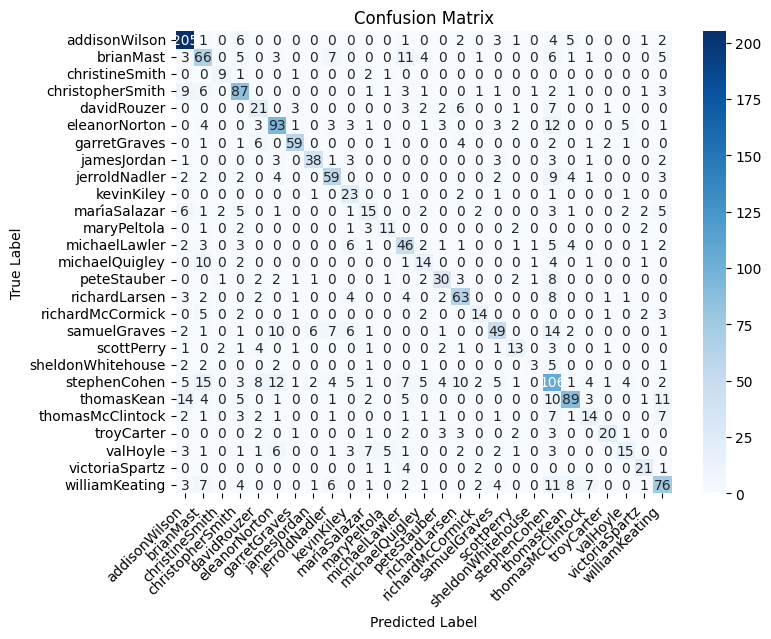

In [ ]:
# Decode the labels back to original format
#y_test_decoded = label_encoder.inverse_transform(y_test)
#y_pred_decoded = label_encoder.inverse_transform(y_predict)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_predict)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Try RNN LSTM approach

### Training and testing

In [ ]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(features, label_enc, test_size=0.2, random_state=42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(label_enc)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
history = model.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=32)

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.1901 - loss: 2.8050
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4612 - loss: 1.7136
Epoch 3/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5903 - loss: 1.3546
Epoch 4/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6356 - loss: 1.1508
Epoch 5/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.6749 - loss: 1.0233
Epoch 6/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7158 - loss: 0.8974
Epoch 7/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7366 - loss: 0.8250
Epoch 8/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7632 - loss: 0.7526
Epoch 9/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7848 - loss: 0.6830
Epoch 10/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.7966 - loss: 0.6281
Epoch 11/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8044 - loss: 0.5995
Epoch 12/20
259/259 ━━━━━━━━━━

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
Test Evaluation Accuracy: 0.8049370764762827


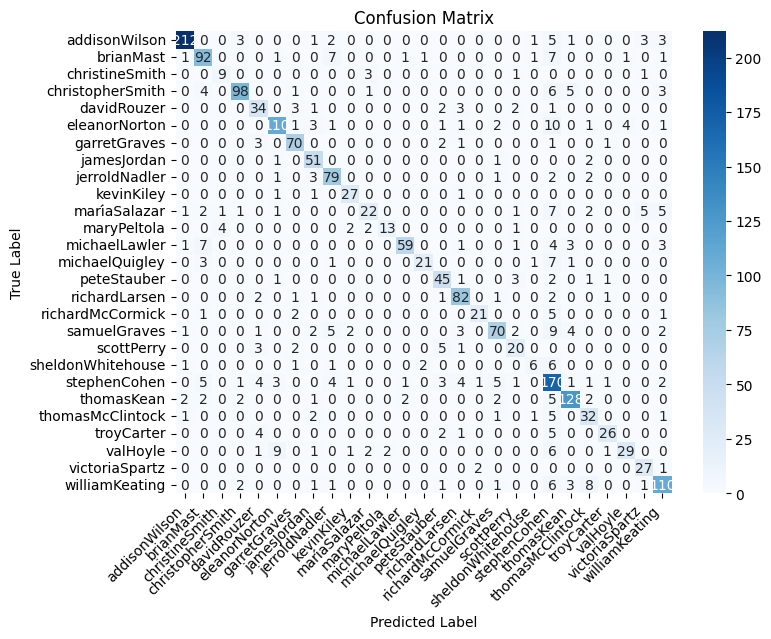

In [ ]:
y_pred_probabilities = model.predict(X_test_rnn)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Try GRU RNN approach

In [ ]:
num_speakers = len(next(os.walk(proccesed_data_dir))[1])

np.random.seed(42)
tf.random.set_seed(42)

y_train_one_hot = to_categorical(y_train_rnn, num_classes=num_speakers)  # n = number of speakers
y_test_one_hot = to_categorical(y_test_rnn, num_classes=num_speakers)

gru = Sequential()
gru.add(GRU(128, return_sequences = False, input_shape = (32,13))) 
gru.add(BatchNormalization())
gru.add(Dropout(.5))
gru.add(Dense(num_speakers, activation = 'softmax'))
# Compile the model
gru.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
gru.summary()

/Users/ryanbirmingham/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128)            │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │         3,483 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,907 (230.11 KB)

 Trainable params: 58,651 (229.11 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = gru.fit(X_train_rnn, y_train_one_hot,
                  epochs=20,
                  batch_size=32,
                  validation_data=(X_test_rnn, y_test_one_hot),
                  callbacks=[early_stopping])

Epoch 1/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.2002 - loss: 3.0650 - val_accuracy: 0.3379 - val_loss: 2.5156
Epoch 2/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.4978 - loss: 1.6803 - val_accuracy: 0.3393 - val_loss: 2.8065
Epoch 3/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5563 - loss: 1.4594 - val_accuracy: 0.2009 - val_loss: 4.3747
Epoch 4/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5863 - loss: 1.3547 - val_accuracy: 0.4811 - val_loss: 1.6809
Epoch 5/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6161 - loss: 1.2541 - val_accuracy: 0.4526 - val_loss: 1.8115
Epoch 6/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.6282 - loss: 1.1828 - val_accuracy: 0.4022 - val_loss: 2.4229
Epoch 7/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6478 - loss: 1.1115 - val_accuracy: 0.5257 - val_loss: 1.6069
Epoch 8/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6734 - loss: 1.0425 - 

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
2066
Test Evaluation Accuracy: 0.7066795740561471


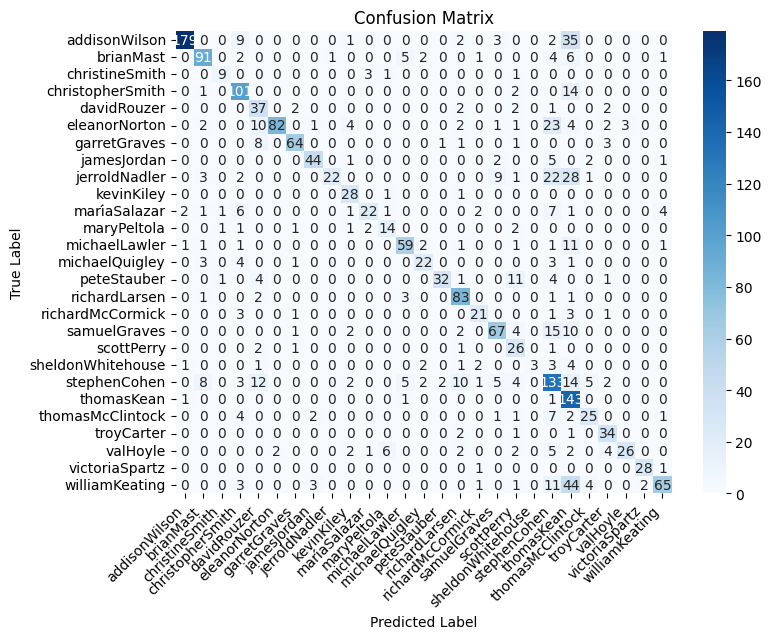

In [ ]:
y_pred_probabilities = gru.predict(X_test_rnn)

y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode the labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
print(len(y_pred_decoded))
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=np.unique(labels))

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()